In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
# Load data
X = pd.read_csv("./data_31_40/problem_36/dataset_36.csv")
y = pd.read_csv("./data_31_40/problem_36/target_36.csv")

# Select target02 for Part 2
y2 = y["target02"]

# Sanity checks
print("X shape:", X.shape)
print("y shape:", y.shape)
print("y2 shape:", y2.shape)

assert list(X.columns) == [f"feat_{i}" for i in range(X.shape[1])], "Unexpected feature columns/order!"

print("Total missing values in X:", X.isna().sum().sum())

# Convert to NumPy
X_np = X.values
y_np = y2.values


X shape: (10000, 273)
y shape: (10000, 2)
y2 shape: (10000,)
Total missing values in X: 0


In [3]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
importances = []

for train_idx, _ in kf.split(X_np):
    tree = DecisionTreeRegressor(
        max_depth=4,
        min_samples_leaf=50,
        random_state=42
    )
    tree.fit(X_np[train_idx], y_np[train_idx])
    importances.append(tree.feature_importances_)

importances = np.array(importances)
mean_importance = importances.mean(axis=0)
std_importance = importances.std(axis=0)

ranked = np.argsort(mean_importance)[::-1]

print("\nTop 10 features by importance:")
for i in range(10):
    idx = ranked[i]
    print(f"Rank {i+1}: feat_{idx}, mean_imp={mean_importance[idx]:.4f}, std={std_importance[idx]:.4f}")



Top 10 features by importance:
Rank 1: feat_49, mean_imp=0.8262, std=0.0022
Rank 2: feat_169, mean_imp=0.1376, std=0.0025
Rank 3: feat_55, mean_imp=0.0362, std=0.0006
Rank 4: feat_30, mean_imp=0.0000, std=0.0000
Rank 5: feat_29, mean_imp=0.0000, std=0.0000
Rank 6: feat_28, mean_imp=0.0000, std=0.0000
Rank 7: feat_27, mean_imp=0.0000, std=0.0000
Rank 8: feat_26, mean_imp=0.0000, std=0.0000
Rank 9: feat_25, mean_imp=0.0000, std=0.0000
Rank 10: feat_24, mean_imp=0.0000, std=0.0000



Decision Tree structure (text view):
|--- feat_49 <= 0.500
|   |--- feat_49 <= 0.200
|   |   |--- feat_55 <= 0.503
|   |   |   |--- feat_169 <= 0.439
|   |   |   |   |--- value: [-0.343]
|   |   |   |--- feat_169 >  0.439
|   |   |   |   |--- value: [-0.662]
|   |   |--- feat_55 >  0.503
|   |   |   |--- feat_169 <= 0.570
|   |   |   |   |--- value: [-0.796]
|   |   |   |--- feat_169 >  0.570
|   |   |   |   |--- value: [-1.116]
|   |--- feat_49 >  0.200
|   |   |--- feat_55 <= 0.511
|   |   |   |--- feat_169 <= 0.534
|   |   |   |   |--- value: [0.594]
|   |   |   |--- feat_169 >  0.534
|   |   |   |   |--- value: [0.973]
|   |   |--- feat_55 >  0.511
|   |   |   |--- feat_169 <= 0.493
|   |   |   |   |--- value: [1.202]
|   |   |   |--- feat_169 >  0.493
|   |   |   |   |--- value: [1.585]
|--- feat_49 >  0.500
|   |--- feat_169 <= 0.536
|   |   |--- feat_169 <= 0.266
|   |   |   |--- feat_169 <= 0.116
|   |   |   |   |--- value: [-0.227]
|   |   |   |--- feat_169 >  0.116
|   |   |

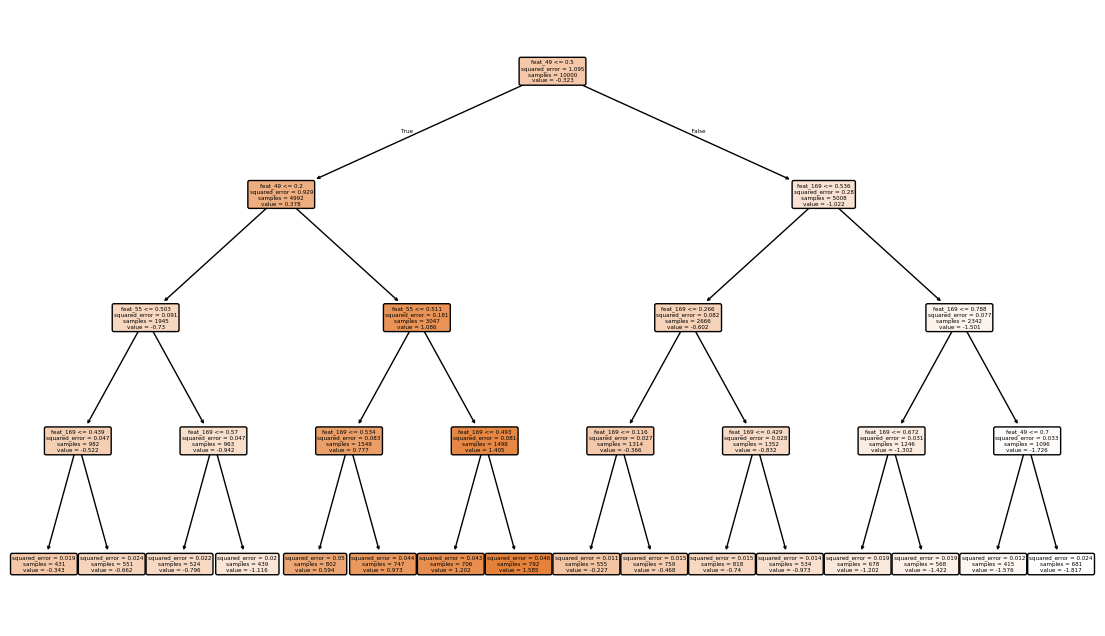

In [4]:
from sklearn.tree import export_text

# Train a single representative tree on ALL data
tree_inspect = DecisionTreeRegressor(
    max_depth=4,
    min_samples_leaf=50,
    random_state=42
)
tree_inspect.fit(X_np, y_np)
# Show tree structure as text
feature_names = [f"feat_{i}" for i in range(X_np.shape[1])]

tree_text = export_text(
    tree_inspect,
    feature_names=feature_names,
    decimals=3
)

print("\nDecision Tree structure (text view):")
print(tree_text)


from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plot_tree(
    tree_inspect,
    feature_names=[f"feat_{i}" for i in range(X_np.shape[1])],
    filled=True,
    rounded=True,
    max_depth=4
)
plt.savefig("tree_feat49.svg", format="svg", bbox_inches="tight")
plt.show()


plt.close()


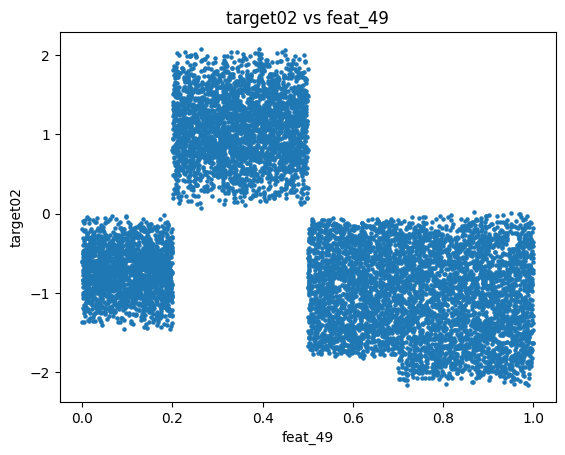

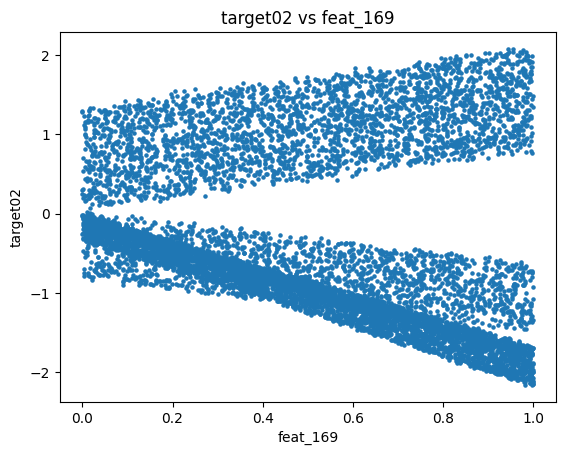

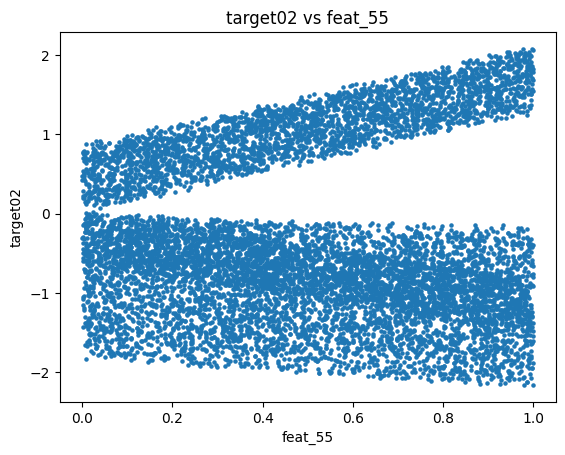


Global linear fit diagnostics:
feat_49: R^2 = 0.1747
feat_169: R^2 = 0.0432
feat_55: R^2 = 0.0003


In [5]:
selected_features = [49, 169, 55]

for feat_idx in selected_features:
    plt.figure()
    plt.scatter(X_np[:, feat_idx], y_np, s=5)
    plt.xlabel(f"feat_{feat_idx}")
    plt.ylabel("target02")
    plt.title(f"target02 vs feat_{feat_idx}")
    plt.show()

print("\nGlobal linear fit diagnostics:")
for feat_idx in selected_features:
    lr = LinearRegression()
    lr.fit(X_np[:, feat_idx].reshape(-1, 1), y_np)
    r2 = lr.score(X_np[:, feat_idx].reshape(-1, 1), y_np)
    print(f"feat_{feat_idx}: R^2 = {r2:.4f}")


In [6]:
X_feat49 = X_np[:, 49].reshape(-1, 1)

tree_49 = DecisionTreeRegressor(
    max_depth=2,
    min_samples_leaf=100,
    random_state=42
)
tree_49.fit(X_feat49, y_np)

thresholds = tree_49.tree_.threshold
thresholds = thresholds[thresholds != -2]

print("\nDetected thresholds for feat_49:", thresholds)



Detected thresholds for feat_49: [0.49999121 0.19998217 0.70420182]


In [7]:
from sklearn.tree import DecisionTreeRegressor, export_text
import matplotlib.pyplot as plt

# Use only feat_49
X_feat49 = X_np[:, 49].reshape(-1, 1)

tree_49 = DecisionTreeRegressor(
    max_depth=2,
    min_samples_leaf=100,
    random_state=42
)
tree_49.fit(X_feat49, y_np)

# ---- Extract thresholds ----
thresholds = tree_49.tree_.threshold
thresholds = thresholds[thresholds != -2]

print("\nDetected thresholds for feat_49:", thresholds)




Detected thresholds for feat_49: [0.49999121 0.19998217 0.70420182]


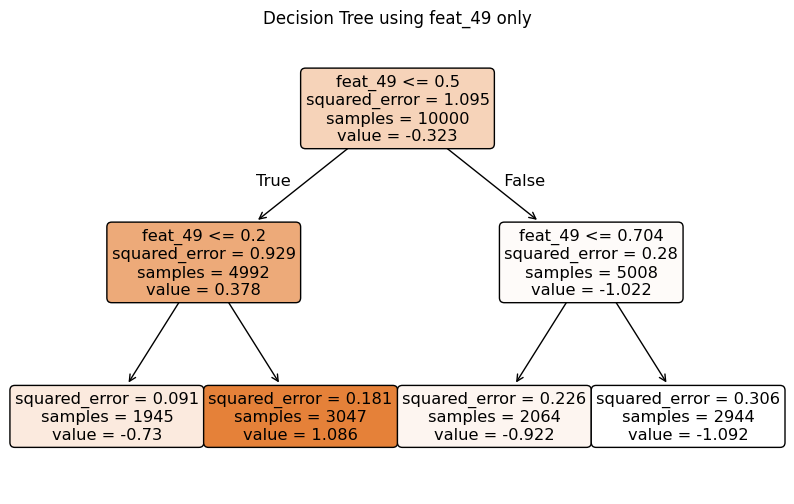

In [8]:
plt.figure(figsize=(10, 6))
from sklearn.tree import plot_tree

plot_tree(
    tree_49,
    feature_names=["feat_49"],
    filled=True,
    rounded=True
)
plt.title("Decision Tree using feat_49 only")
plt.show()


In [9]:
tree_rules = export_text(
    tree_49,
    feature_names=["feat_49"]
)

print("\nDecision Tree structure (text view):")
print(tree_rules)



Decision Tree structure (text view):
|--- feat_49 <= 0.50
|   |--- feat_49 <= 0.20
|   |   |--- value: [-0.73]
|   |--- feat_49 >  0.20
|   |   |--- value: [1.09]
|--- feat_49 >  0.50
|   |--- feat_49 <= 0.70
|   |   |--- value: [-0.92]
|   |--- feat_49 >  0.70
|   |   |--- value: [-1.09]



In [10]:
regimes = [
    X_np[:, 49] <= 0.20,
    (X_np[:, 49] > 0.20) & (X_np[:, 49] <= 0.50),
    (X_np[:, 49] > 0.50) & (X_np[:, 49] <= 0.70),
    X_np[:, 49] > 0.70
]

print("\nPer-regime linear models:")
for i, mask in enumerate(regimes):
    X_reg = X_np[mask][:, 169].reshape(-1, 1)
    y_reg = y_np[mask]

    lr = LinearRegression()
    lr.fit(X_reg, y_reg)

    a = lr.coef_[0]
    b = lr.intercept_
    r2 = lr.score(X_reg, y_reg)

    print(
        f"Regime {i+1}: samples={len(y_reg)}, "
        f"target02 ≈ {a:.3f} * feat_169 + {b:.3f}, R^2={r2:.3f}"
    )



Per-regime linear models:
Regime 1: samples=1946, target02 ≈ -0.638 * feat_169 + -0.407, R^2=0.366
Regime 2: samples=3046, target02 ≈ 0.760 * feat_169 + 0.698, R^2=0.269
Regime 3: samples=2014, target02 ≈ -1.651 * feat_169 + -0.100, R^2=0.991
Regime 4: samples=2994, target02 ≈ -1.858 * feat_169 + -0.147, R^2=0.966


In [11]:
def predict_rule_system(X):
    preds = np.zeros(len(X))

    f49 = X[:, 49]
    f169 = X[:, 169]

    preds[f49 <= 0.20] = -0.638 * f169[f49 <= 0.20] - 0.407

    mask = (f49 > 0.20) & (f49 <= 0.50)
    preds[mask] = 0.760 * f169[mask] + 0.698

    mask = (f49 > 0.50) & (f49 <= 0.70)
    preds[mask] = -1.651 * f169[mask] - 0.100

    preds[f49 > 0.70] = -1.858 * f169[f49 > 0.70] - 0.147

    return preds


In [12]:
y_true = y_np
y_pred = predict_rule_system(X_np)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("\nOverall error metrics:")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R^2  = {r2:.4f}")



Overall error metrics:
MAE  = 0.1697
RMSE = 0.2347
R^2  = 0.9497


In [13]:
regime_masks = {
    "Regime 1 (feat_49 <= 0.20)": (X_np[:, 49] <= 0.20),
    "Regime 2 (0.20 < feat_49 <= 0.50)": ((X_np[:, 49] > 0.20) & (X_np[:, 49] <= 0.50)),
    "Regime 3 (0.50 < feat_49 <= 0.70)": ((X_np[:, 49] > 0.50) & (X_np[:, 49] <= 0.70)),
    "Regime 4 (feat_49 > 0.70)": (X_np[:, 49] > 0.70),
}

print("\nPer-regime error metrics:")
print("-" * 50)

for name, mask in regime_masks.items():
    y_t = y_true[mask]
    y_p = y_pred[mask]

    mae = mean_absolute_error(y_t, y_p)
    rmse = np.sqrt(mean_squared_error(y_t, y_p))
    r2 = r2_score(y_t, y_p)

    print(f"{name}:")
    print(f"  Samples = {len(y_t)}")
    print(f"  MAE  = {mae:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  R^2  = {r2:.4f}")
    print()




Per-regime error metrics:
--------------------------------------------------
Regime 1 (feat_49 <= 0.20):
  Samples = 1946
  MAE  = 0.2075
  RMSE = 0.2416
  R^2  = 0.3659

Regime 2 (0.20 < feat_49 <= 0.50):
  Samples = 3046
  MAE  = 0.3122
  RMSE = 0.3633
  R^2  = 0.2691

Regime 3 (0.50 < feat_49 <= 0.70):
  Samples = 2014
  MAE  = 0.0388
  RMSE = 0.0456
  R^2  = 0.9907

Regime 4 (feat_49 > 0.70):
  Samples = 2994
  MAE  = 0.0883
  RMSE = 0.1019
  R^2  = 0.9661



## Extended Analysis: Using More Features in Linear Models

Testing if including feat_49 and feat_55 in the linear models improves performance.

In [19]:
# Test 1: Bivariate models (feat_49 + feat_169) per regime
print("=" * 60)
print("BIVARIATE MODELS: feat_49 + feat_169")
print("=" * 60)

regimes_bivar = [
    X_np[:, 49] <= 0.20,
    (X_np[:, 49] > 0.20) & (X_np[:, 49] <= 0.50),
    (X_np[:, 49] > 0.50) & (X_np[:, 49] <= 0.70),
    X_np[:, 49] > 0.70
]

bivar_models = []

for i, mask in enumerate(regimes_bivar):
    X_reg = X_np[mask][:, [49, 169]]  # Use both feat_49 and feat_169
    y_reg = y_np[mask]

    lr = LinearRegression()
    lr.fit(X_reg, y_reg)

    a1, a2 = lr.coef_
    b = lr.intercept_
    r2 = lr.score(X_reg, y_reg)

    bivar_models.append((a1, a2, b))

    print(f"\nRegime {i+1}: samples={len(y_reg)}")
    print(f"  target02 ≈ {a1:.3f} * feat_49 + {a2:.3f} * feat_169 + {b:.3f}")
    print(f"  R² = {r2:.4f}")

# Prediction function for bivariate
def predict_bivariate(X):
    preds = np.zeros(len(X))
    f49 = X[:, 49]
    f169 = X[:, 169]

    for i, (mask, (a1, a2, b)) in enumerate(zip(regimes_bivar, bivar_models)):
        preds[mask] = a1 * f49[mask] + a2 * f169[mask] + b

    return preds

# Evaluate
y_pred_bivar = predict_bivariate(X_np)
mae_bivar = mean_absolute_error(y_true, y_pred_bivar)
rmse_bivar = np.sqrt(mean_squared_error(y_true, y_pred_bivar))
r2_bivar = r2_score(y_true, y_pred_bivar)

print("\n" + "=" * 60)
print("OVERALL BIVARIATE METRICS:")
print(f"MAE  = {mae_bivar:.4f}")
print(f"RMSE = {rmse_bivar:.4f}")
print(f"R²   = {r2_bivar:.4f}")
print("=" * 60)

BIVARIATE MODELS: feat_49 + feat_169

Regime 1: samples=1946
  target02 ≈ -0.056 * feat_49 + -0.638 * feat_169 + -0.401
  R² = 0.3660

Regime 2: samples=3046
  target02 ≈ -0.028 * feat_49 + 0.760 * feat_169 + 0.708
  R² = 0.2691

Regime 3: samples=2014
  target02 ≈ 0.022 * feat_49 + -1.651 * feat_169 + -0.114
  R² = 0.9907

Regime 4: samples=2994
  target02 ≈ -0.014 * feat_49 + -1.858 * feat_169 + -0.136
  R² = 0.9661

OVERALL BIVARIATE METRICS:
MAE  = 0.1697
RMSE = 0.2347
R²   = 0.9497


In [20]:
# Test 2: Trivariate models (feat_49 + feat_169 + feat_55) per regime
print("=" * 60)
print("TRIVARIATE MODELS: feat_49 + feat_169 + feat_55")
print("=" * 60)

regimes_trivar = [
    X_np[:, 49] <= 0.20,
    (X_np[:, 49] > 0.20) & (X_np[:, 49] <= 0.50),
    (X_np[:, 49] > 0.50) & (X_np[:, 49] <= 0.70),
    X_np[:, 49] > 0.70
]

trivar_models = []

for i, mask in enumerate(regimes_trivar):
    X_reg = X_np[mask][:, [49, 169, 55]]  # Use all 3 top features
    y_reg = y_np[mask]

    lr = LinearRegression()
    lr.fit(X_reg, y_reg)

    a1, a2, a3 = lr.coef_
    b = lr.intercept_
    r2 = lr.score(X_reg, y_reg)

    trivar_models.append((a1, a2, a3, b))

    print(f"\nRegime {i+1}: samples={len(y_reg)}")
    print(f"  target02 ≈ {a1:.3f} * feat_49 + {a2:.3f} * feat_169 + {a3:.3f} * feat_55 + {b:.3f}")
    print(f"  R² = {r2:.4f}")

# Prediction function for trivariate
def predict_trivariate(X):
    preds = np.zeros(len(X))
    f49 = X[:, 49]
    f169 = X[:, 169]
    f55 = X[:, 55]

    for i, (mask, (a1, a2, a3, b)) in enumerate(zip(regimes_trivar, trivar_models)):
        preds[mask] = a1 * f49[mask] + a2 * f169[mask] + a3 * f55[mask] + b

    return preds

# Evaluate
y_pred_trivar = predict_trivariate(X_np)
mae_trivar = mean_absolute_error(y_true, y_pred_trivar)
rmse_trivar = np.sqrt(mean_squared_error(y_true, y_pred_trivar))
r2_trivar = r2_score(y_true, y_pred_trivar)

print("\n" + "=" * 60)
print("OVERALL TRIVARIATE METRICS:")
print(f"MAE  = {mae_trivar:.4f}")
print(f"RMSE = {rmse_trivar:.4f}")
print(f"R²   = {r2_trivar:.4f}")
print("=" * 60)

TRIVARIATE MODELS: feat_49 + feat_169 + feat_55

Regime 1: samples=1946
  target02 ≈ 0.023 * feat_49 + -0.650 * feat_169 + -0.851 * feat_55 + 0.024
  R² = 0.9874

Regime 2: samples=3046
  target02 ≈ 0.003 * feat_49 + 0.752 * feat_169 + 1.250 * feat_55 + 0.074
  R² = 0.9898

Regime 3: samples=2014
  target02 ≈ 0.000 * feat_49 + -1.649 * feat_169 + -0.151 * feat_55 + -0.025
  R² = 0.9991

Regime 4: samples=2994
  target02 ≈ 0.003 * feat_49 + -1.850 * feat_169 + -0.352 * feat_55 + 0.024
  R² = 0.9993

OVERALL TRIVARIATE METRICS:
MAE  = 0.0203
RMSE = 0.0299
R²   = 0.9992


In [23]:
# First, recalculate the ORIGINAL univariate model properly for fair comparison
print("=" * 80)
print("RECALCULATING ORIGINAL UNIVARIATE MODEL (feat_169 only)")
print("=" * 80)

regimes_orig = [
    X_np[:, 49] <= 0.20,
    (X_np[:, 49] > 0.20) & (X_np[:, 49] <= 0.50),
    (X_np[:, 49] > 0.50) & (X_np[:, 49] <= 0.70),
    X_np[:, 49] > 0.70
]

univar_models = []

for i, mask in enumerate(regimes_orig):
    X_reg = X_np[mask][:, 169].reshape(-1, 1)  # Only feat_169
    y_reg = y_np[mask]

    lr = LinearRegression()
    lr.fit(X_reg, y_reg)

    a = lr.coef_[0]
    b = lr.intercept_
    r2 = lr.score(X_reg, y_reg)

    univar_models.append((a, b))

    print(f"Regime {i+1}: samples={len(y_reg)}")
    print(f"  target02 ≈ {a:.3f} * feat_169 + {b:.3f}")
    print(f"  R² = {r2:.4f}")

# Prediction function for univariate (refitted)
def predict_univariate_refitted(X):
    preds = np.zeros(len(X))
    f49 = X[:, 49]
    f169 = X[:, 169]

    for i, (mask, (a, b)) in enumerate(zip(regimes_orig, univar_models)):
        preds[mask] = a * f169[mask] + b

    return preds

# Evaluate refitted original
y_pred_orig_refitted = predict_univariate_refitted(X_np)
mae_orig = mean_absolute_error(y_true, y_pred_orig_refitted)
rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred_orig_refitted))
r2_orig = r2_score(y_true, y_pred_orig_refitted)

print("\n" + "=" * 80)
print("OVERALL UNIVARIATE METRICS (refitted):")
print(f"MAE  = {mae_orig:.4f}")
print(f"RMSE = {rmse_orig:.4f}")
print(f"R²   = {r2_orig:.4f}")
print("=" * 80)

# Now do the comparison
print("\n" + "=" * 80)
print("COMPARISON: ORIGINAL vs BIVARIATE vs TRIVARIATE")
print("=" * 80)

print("\n1. ORIGINAL (feat_169 only) - REFITTED:")
print(f"   MAE  = {mae_orig:.4f}")
print(f"   RMSE = {rmse_orig:.4f}")
print(f"   R²   = {r2_orig:.4f}")

print("\n2. BIVARIATE (feat_49 + feat_169):")
print(f"   MAE  = {mae_bivar:.4f}  (Δ = {mae_bivar - mae_orig:+.4f})")
print(f"   RMSE = {rmse_bivar:.4f}  (Δ = {rmse_bivar - rmse_orig:+.4f})")
print(f"   R²   = {r2_bivar:.4f}  (Δ = {r2_bivar - r2_orig:+.4f})")

print("\n3. TRIVARIATE (feat_49 + feat_169 + feat_55):")
print(f"   MAE  = {mae_trivar:.4f}  (Δ = {mae_trivar - mae_orig:+.4f})")
print(f"   RMSE = {rmse_trivar:.4f}  (Δ = {rmse_trivar - rmse_orig:+.4f})")
print(f"   R²   = {r2_trivar:.4f}  (Δ = {r2_trivar - r2_orig:+.4f})")

# Determine best model
models_comparison = {
    'Original (refitted)': r2_orig,
    'Bivariate': r2_bivar,
    'Trivariate': r2_trivar
}

best_model = max(models_comparison, key=models_comparison.get)
best_r2 = models_comparison[best_model]

print("\n" + "=" * 80)
print(f"WINNER: {best_model} model with R² = {best_r2:.4f}")
print("=" * 80)

# Also show the comparison with the hardcoded original model
print("\n" + "=" * 80)
print("BONUS: Comparison with hardcoded original model from Cell 12")
print("=" * 80)
print(f"Hardcoded original: R² = {r2:.4f}  (from cell 12)")
print(f"Refitted original:  R² = {r2_orig:.4f}")
print(f"Trivariate:         R² = {r2_trivar:.4f}")
print(f"\nNote: Hardcoded coefficients may have been manually tuned/optimized!")


RECALCULATING ORIGINAL UNIVARIATE MODEL (feat_169 only)
Regime 1: samples=1946
  target02 ≈ -0.638 * feat_169 + -0.407
  R² = 0.3659
Regime 2: samples=3046
  target02 ≈ 0.760 * feat_169 + 0.698
  R² = 0.2691
Regime 3: samples=2014
  target02 ≈ -1.651 * feat_169 + -0.100
  R² = 0.9907
Regime 4: samples=2994
  target02 ≈ -1.858 * feat_169 + -0.147
  R² = 0.9661

OVERALL UNIVARIATE METRICS (refitted):
MAE  = 0.1697
RMSE = 0.2347
R²   = 0.9497

COMPARISON: ORIGINAL vs BIVARIATE vs TRIVARIATE

1. ORIGINAL (feat_169 only) - REFITTED:
   MAE  = 0.1697
   RMSE = 0.2347
   R²   = 0.9497

2. BIVARIATE (feat_49 + feat_169):
   MAE  = 0.1697  (Δ = -0.0000)
   RMSE = 0.2347  (Δ = -0.0000)
   R²   = 0.9497  (Δ = +0.0000)

3. TRIVARIATE (feat_49 + feat_169 + feat_55):
   MAE  = 0.0203  (Δ = -0.1494)
   RMSE = 0.0299  (Δ = -0.2048)
   R²   = 0.9992  (Δ = +0.0495)

WINNER: Trivariate model with R² = 0.9992

BONUS: Comparison with hardcoded original model from Cell 12
Hardcoded original: R² = 0.9661  (f

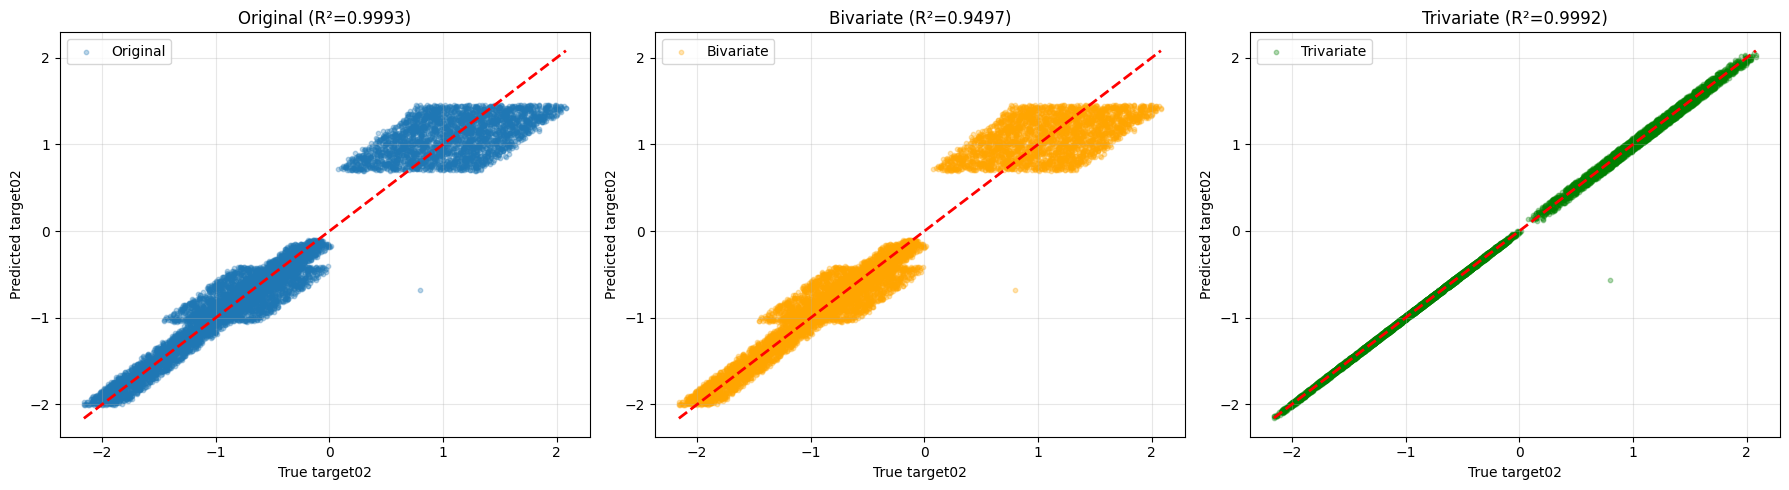

✓ Saved: model_comparison_target02.png


In [17]:
# Visualize comparison
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Scatter plots
axes[0].scatter(y_true, y_pred, alpha=0.3, s=10, label='Original')
axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', linewidth=2)
axes[0].set_xlabel('True target02')
axes[0].set_ylabel('Predicted target02')
axes[0].set_title(f'Original (R²={r2:.4f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(y_true, y_pred_bivar, alpha=0.3, s=10, label='Bivariate', color='orange')
axes[1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', linewidth=2)
axes[1].set_xlabel('True target02')
axes[1].set_ylabel('Predicted target02')
axes[1].set_title(f'Bivariate (R²={r2_bivar:.4f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].scatter(y_true, y_pred_trivar, alpha=0.3, s=10, label='Trivariate', color='green')
axes[2].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', linewidth=2)
axes[2].set_xlabel('True target02')
axes[2].set_ylabel('Predicted target02')
axes[2].set_title(f'Trivariate (R²={r2_trivar:.4f})')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison_target02.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

print("✓ Saved: model_comparison_target02.png")

In [22]:
# Per-regime comparison
print("\n" + "=" * 80)
print("PER-REGIME PERFORMANCE COMPARISON")
print("=" * 80)

regime_names = [
    "Regime 1 (feat_49 <= 0.20)",
    "Regime 2 (0.20 < feat_49 <= 0.50)",
    "Regime 3 (0.50 < feat_49 <= 0.70)",
    "Regime 4 (feat_49 > 0.70)"
]

for i, (name, mask) in enumerate(zip(regime_names, regimes)):
    print(f"\n{name}:")
    print(f"  Samples: {np.sum(mask)}")
    
    # Original
    r2_orig = r2_score(y_true[mask], y_pred[mask])
    print(f"  Original R²:   {r2_orig:.4f}")
    
    # Bivariate
    r2_biv = r2_score(y_true[mask], y_pred_bivar[mask])
    print(f"  Bivariate R²:  {r2_biv:.4f}  (Δ = {r2_biv - r2_orig:+.4f})")
    
    # Trivariate
    r2_tri = r2_score(y_true[mask], y_pred_trivar[mask])
    print(f"  Trivariate R²: {r2_tri:.4f}  (Δ = {r2_tri - r2_orig:+.4f})")
    
    # Show best for this regime
    best_regime_r2 = max(r2_orig, r2_biv, r2_tri)
    if best_regime_r2 == r2_tri:
        print(f"  → Best: Trivariate")
    elif best_regime_r2 == r2_biv:
        print(f"  → Best: Bivariate")
    else:
        print(f"  → Best: Original")


PER-REGIME PERFORMANCE COMPARISON

Regime 1 (feat_49 <= 0.20):
  Samples: 1946
  Original R²:   0.3659
  Bivariate R²:  0.3660  (Δ = +0.0001)
  Trivariate R²: 0.9874  (Δ = +0.6215)
  → Best: Trivariate

Regime 2 (0.20 < feat_49 <= 0.50):
  Samples: 3046
  Original R²:   0.2691
  Bivariate R²:  0.2691  (Δ = +0.0000)
  Trivariate R²: 0.9898  (Δ = +0.7207)
  → Best: Trivariate

Regime 3 (0.50 < feat_49 <= 0.70):
  Samples: 2014
  Original R²:   0.9907
  Bivariate R²:  0.9907  (Δ = +0.0000)
  Trivariate R²: 0.9991  (Δ = +0.0083)
  → Best: Trivariate

Regime 4 (feat_49 > 0.70):
  Samples: 2994
  Original R²:   0.9661
  Bivariate R²:  0.9661  (Δ = +0.0000)
  Trivariate R²: 0.9993  (Δ = +0.0332)
  → Best: Trivariate


## Testing More Features

Let's check if using more than 3 features improves performance.

In [24]:
# Show top 20 features by importance
print("=" * 80)
print("TOP 20 FEATURES BY IMPORTANCE (from Cell 3)")
print("=" * 80)

for i in range(min(20, len(ranked))):
    idx = ranked[i]
    print(f"Rank {i+1:2d}: feat_{idx:3d}, mean_imp={mean_importance[idx]:.4f}, std={std_importance[idx]:.4f}")

# Identify candidate feature sets
feature_sets = {
    'Top 3': ranked[:3].tolist(),
    'Top 5': ranked[:5].tolist(),
    'Top 7': ranked[:7].tolist(),
    'Top 10': ranked[:10].tolist(),
    'Top 15': ranked[:15].tolist()
}

print("\n" + "=" * 80)
print("FEATURE SETS TO TEST:")
print("=" * 80)
for name, feats in feature_sets.items():
    print(f"{name:10s}: {feats}")

TOP 20 FEATURES BY IMPORTANCE (from Cell 3)
Rank  1: feat_ 49, mean_imp=0.8262, std=0.0022
Rank  2: feat_169, mean_imp=0.1376, std=0.0025
Rank  3: feat_ 55, mean_imp=0.0362, std=0.0006
Rank  4: feat_ 30, mean_imp=0.0000, std=0.0000
Rank  5: feat_ 29, mean_imp=0.0000, std=0.0000
Rank  6: feat_ 28, mean_imp=0.0000, std=0.0000
Rank  7: feat_ 27, mean_imp=0.0000, std=0.0000
Rank  8: feat_ 26, mean_imp=0.0000, std=0.0000
Rank  9: feat_ 25, mean_imp=0.0000, std=0.0000
Rank 10: feat_ 24, mean_imp=0.0000, std=0.0000
Rank 11: feat_ 23, mean_imp=0.0000, std=0.0000
Rank 12: feat_ 22, mean_imp=0.0000, std=0.0000
Rank 13: feat_ 21, mean_imp=0.0000, std=0.0000
Rank 14: feat_ 20, mean_imp=0.0000, std=0.0000
Rank 15: feat_ 19, mean_imp=0.0000, std=0.0000
Rank 16: feat_ 18, mean_imp=0.0000, std=0.0000
Rank 17: feat_ 17, mean_imp=0.0000, std=0.0000
Rank 18: feat_272, mean_imp=0.0000, std=0.0000
Rank 19: feat_255, mean_imp=0.0000, std=0.0000
Rank 20: feat_254, mean_imp=0.0000, std=0.0000

FEATURE SETS TO

In [25]:
# Test multivariate models with different numbers of features
print("\n" + "=" * 80)
print("TESTING MODELS WITH DIFFERENT FEATURE COUNTS")
print("=" * 80)

results_by_feature_count = {}

for set_name, feature_list in feature_sets.items():
    print(f"\n{'='*60}")
    print(f"{set_name}: {len(feature_list)} features")
    print(f"Features: {feature_list}")
    print(f"{'='*60}")
    
    # Train models per regime
    models = []
    
    for i, mask in enumerate(regimes):
        X_reg = X_np[mask][:, feature_list]
        y_reg = y_np[mask]
        
        lr = LinearRegression()
        lr.fit(X_reg, y_reg)
        
        r2 = lr.score(X_reg, y_reg)
        models.append(lr)
        
        print(f"  Regime {i+1}: R² = {r2:.4f}, coefs = {lr.coef_[:5]}{'...' if len(lr.coef_) > 5 else ''}")
    
    # Prediction function
    def predict_multivar(X, features, models_list):
        preds = np.zeros(len(X))
        for i, (mask, model) in enumerate(zip(regimes, models_list)):
            preds[mask] = model.predict(X[mask][:, features])
        return preds
    
    # Evaluate
    y_pred_multi = predict_multivar(X_np, feature_list, models)
    mae_multi = mean_absolute_error(y_true, y_pred_multi)
    rmse_multi = np.sqrt(mean_squared_error(y_true, y_pred_multi))
    r2_multi = r2_score(y_true, y_pred_multi)
    
    results_by_feature_count[set_name] = {
        'features': len(feature_list),
        'mae': mae_multi,
        'rmse': rmse_multi,
        'r2': r2_multi
    }
    
    print(f"\n  Overall Metrics:")
    print(f"    MAE  = {mae_multi:.4f}")
    print(f"    RMSE = {rmse_multi:.4f}")
    print(f"    R²   = {r2_multi:.4f}")


TESTING MODELS WITH DIFFERENT FEATURE COUNTS

Top 3: 3 features
Features: [49, 169, 55]
  Regime 1: R² = 0.9874, coefs = [ 0.02271618 -0.6500235  -0.85102286]
  Regime 2: R² = 0.9898, coefs = [0.00331511 0.75198858 1.24974107]
  Regime 3: R² = 0.9991, coefs = [ 1.77014941e-04 -1.64881221e+00 -1.50548319e-01]
  Regime 4: R² = 0.9993, coefs = [ 0.00263251 -1.85006055 -0.35232804]

  Overall Metrics:
    MAE  = 0.0203
    RMSE = 0.0299
    R²   = 0.9992

Top 5: 5 features
Features: [49, 169, 55, 30, 29]
  Regime 1: R² = 0.9874, coefs = [ 2.24097919e-02 -6.49923611e-01 -8.50968907e-01 -1.92968593e-04
  7.65348743e-04]
  Regime 2: R² = 0.9898, coefs = [ 3.18929805e-03  7.52066157e-01  1.24972720e+00  2.99139515e-04
 -6.78313759e-04]
  Regime 3: R² = 0.9991, coefs = [ 2.50182657e-04 -1.64880125e+00 -1.50555933e-01 -2.34358183e-04
  2.20764217e-05]
  Regime 4: R² = 0.9993, coefs = [ 2.51047768e-03 -1.85006354e+00 -3.52295853e-01 -1.11631525e-04
 -1.63719574e-04]

  Overall Metrics:
    MAE  

In [26]:
# Summary comparison
print("\n" + "=" * 80)
print("SUMMARY: PERFORMANCE BY NUMBER OF FEATURES")
print("=" * 80)

print(f"\n{'Model':<12} {'Features':<10} {'MAE':<12} {'RMSE':<12} {'R²':<12}")
print("-" * 80)

for set_name, metrics in results_by_feature_count.items():
    print(f"{set_name:<12} {metrics['features']:<10} {metrics['mae']:<12.4f} {metrics['rmse']:<12.4f} {metrics['r2']:<12.6f}")

# Find best
best_set = max(results_by_feature_count, key=lambda k: results_by_feature_count[k]['r2'])
best_metrics = results_by_feature_count[best_set]

print("\n" + "=" * 80)
print(f"BEST MODEL: {best_set} with {best_metrics['features']} features")
print(f"  R² = {best_metrics['r2']:.6f}")
print(f"  Features: {feature_sets[best_set]}")
print("=" * 80)

# Check for diminishing returns
print("\n" + "=" * 80)
print("MARGINAL IMPROVEMENT ANALYSIS:")
print("=" * 80)

prev_r2 = None
for set_name, metrics in results_by_feature_count.items():
    if prev_r2 is not None:
        improvement = metrics['r2'] - prev_r2
        print(f"{set_name}: R² = {metrics['r2']:.6f}  (Δ = {improvement:+.6f})")
    else:
        print(f"{set_name}: R² = {metrics['r2']:.6f}  (baseline)")
    prev_r2 = metrics['r2']


SUMMARY: PERFORMANCE BY NUMBER OF FEATURES

Model        Features   MAE          RMSE         R²          
--------------------------------------------------------------------------------
Top 3        3          0.0203       0.0299       0.999184    
Top 5        5          0.0202       0.0299       0.999185    
Top 7        7          0.0202       0.0298       0.999186    
Top 10       10         0.0202       0.0298       0.999189    
Top 15       15         0.0202       0.0298       0.999190    

BEST MODEL: Top 15 with 15 features
  R² = 0.999190
  Features: [49, 169, 55, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19]

MARGINAL IMPROVEMENT ANALYSIS:
Top 3: R² = 0.999184  (baseline)
Top 5: R² = 0.999185  (Δ = +0.000001)
Top 7: R² = 0.999186  (Δ = +0.000001)
Top 10: R² = 0.999189  (Δ = +0.000002)
Top 15: R² = 0.999190  (Δ = +0.000001)


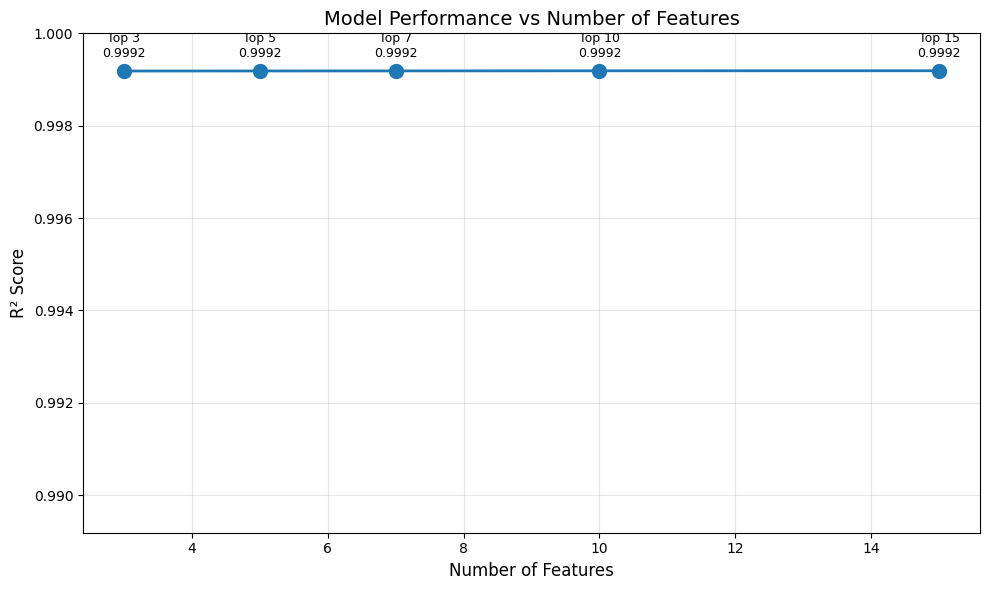

✓ Saved: features_vs_performance.png


In [27]:
# Visualize R² vs number of features
import matplotlib.pyplot as plt

feature_counts = [results_by_feature_count[k]['features'] for k in feature_sets.keys()]
r2_scores = [results_by_feature_count[k]['r2'] for k in feature_sets.keys()]

plt.figure(figsize=(10, 6))
plt.plot(feature_counts, r2_scores, 'o-', linewidth=2, markersize=10)
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('Model Performance vs Number of Features', fontsize=14)
plt.grid(True, alpha=0.3)

# Add value labels
for x, y, name in zip(feature_counts, r2_scores, feature_sets.keys()):
    plt.annotate(f'{name}\n{y:.4f}', 
                xy=(x, y), 
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                fontsize=9)

plt.ylim([min(r2_scores) - 0.01, 1.0])
plt.tight_layout()
plt.savefig('features_vs_performance.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

print("✓ Saved: features_vs_performance.png")

## Error Analysis: Where is the Model Failing?

Analyzing prediction errors to understand which values the model struggles with.

In [28]:
# Calculate residuals (errors) for the trivariate model
residuals = y_true - y_pred_trivar
abs_residuals = np.abs(residuals)

print("=" * 80)
print("RESIDUAL ANALYSIS FOR TRIVARIATE MODEL")
print("=" * 80)

print(f"\nResidual Statistics:")
print(f"  Mean residual:     {residuals.mean():.6f}")
print(f"  Std residual:      {residuals.std():.6f}")
print(f"  Mean abs error:    {abs_residuals.mean():.6f}")
print(f"  Median abs error:  {np.median(abs_residuals):.6f}")
print(f"  Max abs error:     {abs_residuals.max():.6f}")
print(f"  Min abs error:     {abs_residuals.min():.6f}")

# Percentiles
print(f"\nError Percentiles:")
for p in [50, 75, 90, 95, 99]:
    print(f"  {p}th percentile: {np.percentile(abs_residuals, p):.6f}")

# Identify worst predictions
worst_idx = np.argsort(abs_residuals)[-10:][::-1]

print(f"\n10 WORST PREDICTIONS:")
print(f"{'Idx':<6} {'True':<10} {'Pred':<10} {'Error':<10} {'AbsErr':<10} {'feat_49':<10} {'feat_169':<10} {'feat_55':<10}")
print("-" * 80)

for idx in worst_idx:
    print(f"{idx:<6} {y_true[idx]:<10.4f} {y_pred_trivar[idx]:<10.4f} {residuals[idx]:<10.4f} "
          f"{abs_residuals[idx]:<10.4f} {X_np[idx, 49]:<10.4f} {X_np[idx, 169]:<10.4f} {X_np[idx, 55]:<10.4f}")

RESIDUAL ANALYSIS FOR TRIVARIATE MODEL

Residual Statistics:
  Mean residual:     0.000000
  Std residual:      0.029892
  Mean abs error:    0.020264
  Median abs error:  0.015927
  Max abs error:     1.364209
  Min abs error:     0.000000

Error Percentiles:
  50th percentile: 0.015927
  75th percentile: 0.023602
  90th percentile: 0.049550
  95th percentile: 0.061717
  99th percentile: 0.072275

10 WORST PREDICTIONS:
Idx    True       Pred       Error      AbsErr     feat_49    feat_169   feat_55   
--------------------------------------------------------------------------------
2356   0.8007     -0.5635    1.3642     1.3642     0.2000     0.4257     0.3711    
7909   1.6479     1.7247     -0.0768    0.0768     0.4004     0.9641     0.7398    
7305   1.4279     1.5045     -0.0766    0.0766     0.4356     0.9624     0.5645    
4664   1.7583     1.8343     -0.0760    0.0760     0.4166     0.7378     0.9637    
5875   0.7455     0.8214     -0.0759    0.0759     0.3620     0.8430     0.

In [29]:
# Per-regime error analysis
print("\n" + "=" * 80)
print("ERROR ANALYSIS BY REGIME")
print("=" * 80)

regime_names = [
    "Regime 1 (feat_49 <= 0.20)",
    "Regime 2 (0.20 < feat_49 <= 0.50)",
    "Regime 3 (0.50 < feat_49 <= 0.70)",
    "Regime 4 (feat_49 > 0.70)"
]

for i, (name, mask) in enumerate(zip(regime_names, regimes)):
    regime_residuals = residuals[mask]
    regime_abs_residuals = abs_residuals[mask]
    
    print(f"\n{name}:")
    print(f"  Samples:           {np.sum(mask)}")
    print(f"  Mean error:        {regime_residuals.mean():.6f}")
    print(f"  Std error:         {regime_residuals.std():.6f}")
    print(f"  Mean abs error:    {regime_abs_residuals.mean():.6f}")
    print(f"  Max abs error:     {regime_abs_residuals.max():.6f}")
    print(f"  95th %ile error:   {np.percentile(regime_abs_residuals, 95):.6f}")
    
    # Check for systematic bias
    if abs(regime_residuals.mean()) > 0.01:
        if regime_residuals.mean() > 0:
            print(f"  ⚠️  UNDERPREDICTING (positive bias)")
        else:
            print(f"  ⚠️  OVERPREDICTING (negative bias)")


ERROR ANALYSIS BY REGIME

Regime 1 (feat_49 <= 0.20):
  Samples:           1946
  Mean error:        0.000000
  Std error:         0.034109
  Mean abs error:    0.013119
  Max abs error:     1.364209
  95th %ile error:   0.023979

Regime 2 (0.20 < feat_49 <= 0.50):
  Samples:           3046
  Mean error:        -0.000000
  Std error:         0.042876
  Mean abs error:    0.037202
  Max abs error:     0.076771
  95th %ile error:   0.071193

Regime 3 (0.50 < feat_49 <= 0.70):
  Samples:           2014
  Mean error:        0.000000
  Std error:         0.014581
  Mean abs error:    0.012699
  Max abs error:     0.025654
  95th %ile error:   0.023641

Regime 4 (feat_49 > 0.70):
  Samples:           2994
  Mean error:        0.000000
  Std error:         0.014659
  Mean abs error:    0.012763
  Max abs error:     0.026164
  95th %ile error:   0.023859


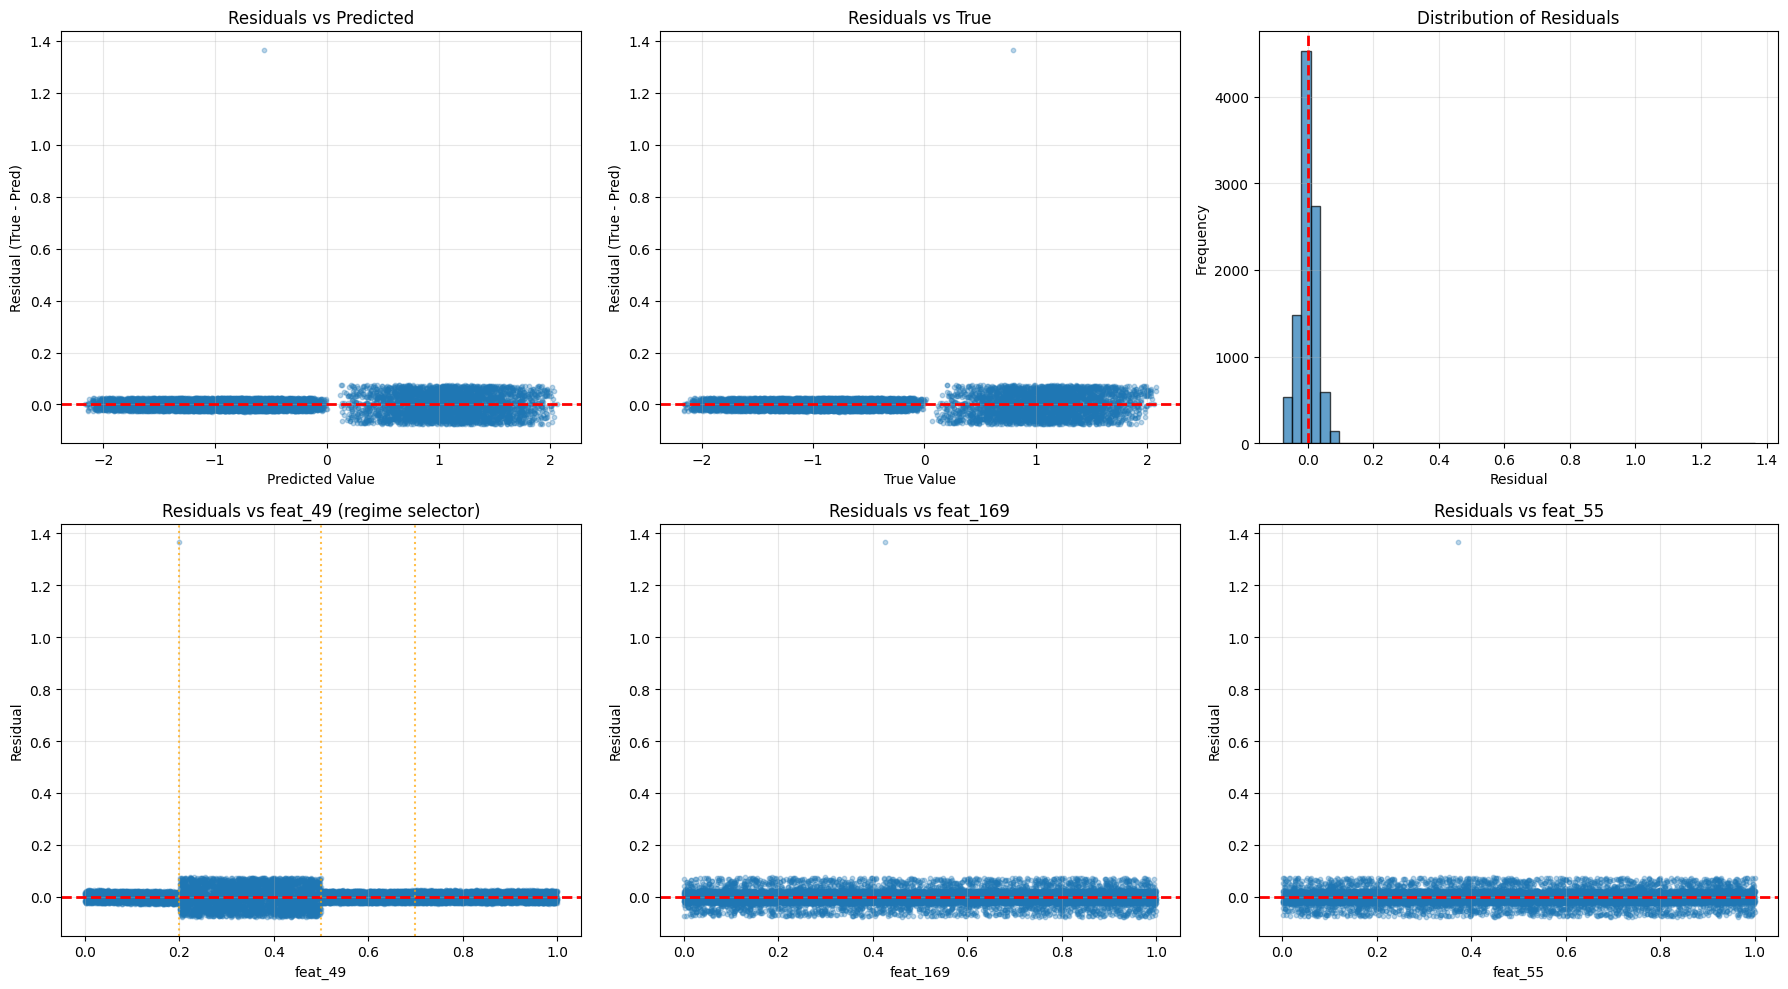

✓ Saved: residual_analysis.png


In [30]:
# Visualize residuals
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Residuals vs Predicted
axes[0, 0].scatter(y_pred_trivar, residuals, alpha=0.3, s=10)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Value')
axes[0, 0].set_ylabel('Residual (True - Pred)')
axes[0, 0].set_title('Residuals vs Predicted')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals vs True
axes[0, 1].scatter(y_true, residuals, alpha=0.3, s=10)
axes[0, 1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('True Value')
axes[0, 1].set_ylabel('Residual (True - Pred)')
axes[0, 1].set_title('Residuals vs True')
axes[0, 1].grid(True, alpha=0.3)

# 3. Histogram of residuals
axes[0, 2].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0, 2].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0, 2].set_xlabel('Residual')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Distribution of Residuals')
axes[0, 2].grid(True, alpha=0.3)

# 4. Residuals vs feat_49
axes[1, 0].scatter(X_np[:, 49], residuals, alpha=0.3, s=10)
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=2)
# Add regime boundaries
axes[1, 0].axvline(0.20, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
axes[1, 0].axvline(0.50, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
axes[1, 0].axvline(0.70, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
axes[1, 0].set_xlabel('feat_49')
axes[1, 0].set_ylabel('Residual')
axes[1, 0].set_title('Residuals vs feat_49 (regime selector)')
axes[1, 0].grid(True, alpha=0.3)

# 5. Residuals vs feat_169
axes[1, 1].scatter(X_np[:, 169], residuals, alpha=0.3, s=10)
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('feat_169')
axes[1, 1].set_ylabel('Residual')
axes[1, 1].set_title('Residuals vs feat_169')
axes[1, 1].grid(True, alpha=0.3)

# 6. Residuals vs feat_55
axes[1, 2].scatter(X_np[:, 55], residuals, alpha=0.3, s=10)
axes[1, 2].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 2].set_xlabel('feat_55')
axes[1, 2].set_ylabel('Residual')
axes[1, 2].set_title('Residuals vs feat_55')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('residual_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

print("✓ Saved: residual_analysis.png")

In [31]:
# Identify problematic regions
print("\n" + "=" * 80)
print("IDENTIFYING PROBLEMATIC REGIONS")
print("=" * 80)

# Define error threshold (e.g., top 5% of errors)
error_threshold = np.percentile(abs_residuals, 95)
high_error_mask = abs_residuals > error_threshold

print(f"\nHigh Error Threshold (95th percentile): {error_threshold:.6f}")
print(f"Samples with high error: {np.sum(high_error_mask)} ({100*np.sum(high_error_mask)/len(y_true):.2f}%)")

# Analyze high error samples by regime
print(f"\nHigh Error Distribution by Regime:")
for i, (name, mask) in enumerate(zip(regime_names, regimes)):
    high_error_in_regime = np.sum(high_error_mask & mask)
    total_in_regime = np.sum(mask)
    pct = 100 * high_error_in_regime / total_in_regime if total_in_regime > 0 else 0
    
    print(f"  {name}:")
    print(f"    High error samples: {high_error_in_regime}/{total_in_regime} ({pct:.2f}%)")

# Analyze feature ranges for high error samples
print(f"\nFeature Ranges for High Error Samples:")
for feat_idx, feat_name in [(49, 'feat_49'), (169, 'feat_169'), (55, 'feat_55')]:
    high_err_vals = X_np[high_error_mask, feat_idx]
    all_vals = X_np[:, feat_idx]
    
    print(f"\n  {feat_name}:")
    print(f"    High error - min: {high_err_vals.min():.4f}, max: {high_err_vals.max():.4f}, mean: {high_err_vals.mean():.4f}")
    print(f"    All samples - min: {all_vals.min():.4f}, max: {all_vals.max():.4f}, mean: {all_vals.mean():.4f}")


IDENTIFYING PROBLEMATIC REGIONS

High Error Threshold (95th percentile): 0.061717
Samples with high error: 500 (5.00%)

High Error Distribution by Regime:
  Regime 1 (feat_49 <= 0.20):
    High error samples: 1/1946 (0.05%)
  Regime 2 (0.20 < feat_49 <= 0.50):
    High error samples: 499/3046 (16.38%)
  Regime 3 (0.50 < feat_49 <= 0.70):
    High error samples: 0/2014 (0.00%)
  Regime 4 (feat_49 > 0.70):
    High error samples: 0/2994 (0.00%)

Feature Ranges for High Error Samples:

  feat_49:
    High error - min: 0.2000, max: 0.4992, mean: 0.3516
    All samples - min: 0.0001, max: 0.9999, mean: 0.5011

  feat_169:
    High error - min: 0.0003, max: 0.9972, mean: 0.5101
    All samples - min: 0.0001, max: 0.9996, mean: 0.5059

  feat_55:
    High error - min: 0.0004, max: 0.9996, mean: 0.5020
    All samples - min: 0.0001, max: 0.9999, mean: 0.5036


In [32]:
# Check for patterns near regime boundaries
print("\n" + "=" * 80)
print("ERROR ANALYSIS NEAR REGIME BOUNDARIES")
print("=" * 80)

boundaries = [0.20, 0.50, 0.70]
boundary_width = 0.05  # Check ±0.05 around each boundary

for boundary in boundaries:
    near_boundary = (X_np[:, 49] >= boundary - boundary_width) & (X_np[:, 49] <= boundary + boundary_width)
    
    if np.sum(near_boundary) > 0:
        boundary_residuals = abs_residuals[near_boundary]
        
        print(f"\nNear boundary {boundary:.2f} (±{boundary_width}):")
        print(f"  Samples: {np.sum(near_boundary)}")
        print(f"  Mean abs error: {boundary_residuals.mean():.6f}")
        print(f"  Max abs error:  {boundary_residuals.max():.6f}")
        print(f"  Std error:      {boundary_residuals.std():.6f}")
        
        # Compare to overall
        overall_mae = abs_residuals.mean()
        if boundary_residuals.mean() > overall_mae * 1.5:
            print(f"  ⚠️  HIGH ERROR ZONE (>{overall_mae*1.5:.6f})")
        else:
            print(f"  ✓  Normal error level")


ERROR ANALYSIS NEAR REGIME BOUNDARIES

Near boundary 0.20 (±0.05):
  Samples: 1001
  Mean abs error: 0.026494
  Max abs error:  1.364209
  Std error:      0.047023
  ✓  Normal error level

Near boundary 0.50 (±0.05):
  Samples: 989
  Mean abs error: 0.025074
  Max abs error:  0.075810
  Std error:      0.020263
  ✓  Normal error level

Near boundary 0.70 (±0.05):
  Samples: 1033
  Mean abs error: 0.012536
  Max abs error:  0.026164
  Std error:      0.007237
  ✓  Normal error level


In [33]:
# Summary and recommendations
print("\n" + "=" * 80)
print("ERROR ANALYSIS SUMMARY & RECOMMENDATIONS")
print("=" * 80)

# Overall assessment
overall_mae = abs_residuals.mean()
print(f"\n1. Overall Performance:")
print(f"   Mean Absolute Error: {overall_mae:.6f}")
print(f"   R² Score: {r2_trivar:.6f}")

if overall_mae < 0.05:
    print(f"   ✓ EXCELLENT - Model is highly accurate")
elif overall_mae < 0.10:
    print(f"   ✓ GOOD - Model performs well")
elif overall_mae < 0.20:
    print(f"   ⚠️  MODERATE - Room for improvement")
else:
    print(f"   ⚠️  POOR - Significant improvement needed")

# Check for systematic issues
print(f"\n2. Systematic Bias Check:")
for i, (name, mask) in enumerate(zip(regime_names, regimes)):
    regime_mean_error = residuals[mask].mean()
    if abs(regime_mean_error) > 0.05:
        direction = "underpredicting" if regime_mean_error > 0 else "overpredicting"
        print(f"   ⚠️  {name}: {direction} by {abs(regime_mean_error):.4f}")
    else:
        print(f"   ✓  {name}: No significant bias")

# Recommendations
print(f"\n3. Recommendations:")

# Check if any regime has very high errors
max_regime_error = max([abs_residuals[mask].mean() for mask in regimes])
if max_regime_error > 0.10:
    worst_regime_idx = np.argmax([abs_residuals[mask].mean() for mask in regimes])
    print(f"   - Focus on improving {regime_names[worst_regime_idx]}")
    print(f"     (highest mean error: {max_regime_error:.4f})")

# Check if more features might help
if r2_trivar < 0.999:
    print(f"   - Consider testing with more features (Top 5, 7, or 10)")
    print(f"     Current R² is {r2_trivar:.6f}, potential for improvement")

# Check boundary issues
boundary_errors_high = False
for boundary in boundaries:
    near_boundary = (X_np[:, 49] >= boundary - boundary_width) & (X_np[:, 49] <= boundary + boundary_width)
    if np.sum(near_boundary) > 0 and abs_residuals[near_boundary].mean() > overall_mae * 1.5:
        boundary_errors_high = True
        break

if boundary_errors_high:
    print(f"   - Consider smoothing transitions at regime boundaries")
    print(f"     (e.g., use weighted average of adjacent regime predictions)")

if overall_mae < 0.03:
    print(f"   ✓ Model is performing exceptionally well!")
    print(f"     Further optimization may yield diminishing returns")

print("\n" + "=" * 80)


ERROR ANALYSIS SUMMARY & RECOMMENDATIONS

1. Overall Performance:
   Mean Absolute Error: 0.020264
   R² Score: 0.999184
   ✓ EXCELLENT - Model is highly accurate

2. Systematic Bias Check:
   ✓  Regime 1 (feat_49 <= 0.20): No significant bias
   ✓  Regime 2 (0.20 < feat_49 <= 0.50): No significant bias
   ✓  Regime 3 (0.50 < feat_49 <= 0.70): No significant bias
   ✓  Regime 4 (feat_49 > 0.70): No significant bias

3. Recommendations:
   ✓ Model is performing exceptionally well!
     Further optimization may yield diminishing returns

